In [38]:
import numpy as np
print(np.__version__ )

import matplotlib.pyplot as plt

import torch
print(torch.__version__)

import math
import random

import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import trange
torch.manual_seed(0)

1.26.4
2.2.1


In [39]:
# Creating the TicTacToe game. 

class TicTakToe:
    def __init__(self):
        self.row_count = 3
        self.col_count = 3
        self.action_size = self.row_count * self.col_count
        
    def get_initial_state(self):
        return np.zeros((self.row_count, self.col_count))

    def get_next_state(self, state, action, player):
        row = action // self.col_count
        col = action % self.col_count
        state[row, col] = player
        return state

    def get_valid_moves(self, state):
        return (state.reshape(-1) == 0).astype(np.uint8)
    
    def check_win(self, state, action):
        
        if action == None:
            return False
        
        row = action // self.col_count
        col = action % self.col_count
        player = state[row, col]
        
        return (
            
            np.sum(state[row, : ]) == player * self.col_count
            or np.sum(state[:, col]) == player * self.row_count
            or np.sum(np.diag(state)) == player * self.col_count
            or np.sum(np.diag(np.flip(state, axis = 0))) == player * self.col_count
        )

    def get_value_and_terminated(self, state, action):
        if self.check_win(state, action):
            # This means someone has won the game
            return 1, True
        if np.sum(self.get_valid_moves(state)) == 0:
            # This means no one has won the game as there are no valid moves
            return 0, True
        # else the game must continue
        return 0, False

    def get_opponent(self, player):
        return -player
    
    def get_opponent_value(self, value):
        return -value
    
    def change_perspective(self, state, player):
        return state * player
    
    def get_encoded_state(self, state):
        encoded_state = np.stack(
            (state == -1, state == 0 , state == 1)
        ).astype(np.float32)
        
        return encoded_state

In [40]:
# building out model ResNet Model and blocks

class ResNet(nn.Module):
    def __init__(self, game, num_resBlocks, num_hidden, device):
        super().__init__()
        self.device = device
        self.startBlock = nn.Sequential(
            nn.Conv2d(3, num_hidden, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_hidden),
            nn.ReLU()
        )
        
        self.backBone = nn.ModuleList(
            [ResBlock(num_hidden) for i in range(num_resBlocks)]
        )
        
        self.policyHead = nn.Sequential(
            nn.Conv2d(num_hidden, 32, kernel_size = 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * game.row_count * game.col_count, game.action_size)
        )
        
        self.valueHead = nn.Sequential(
            nn.Conv2d(num_hidden, 3, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3 * game.row_count * game.col_count,1),
            nn.Tanh()   
        )
        
        self.to(device)
        
    def forward(self, x):
        x = self.startBlock(x)
        for resBlock in self.backBone:
            x = resBlock(x)
        policy = self.policyHead(x)
        value = self.valueHead(x)
        return policy, value
        
class ResBlock(nn.Module):
    def __init__(self, num_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_hidden)
        
    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        x = F.relu(x)
        
        return x

[[ 0.  0. -1.]
 [ 0. -1.  0.]
 [ 1.  0.  1.]]
[[[0. 0. 1.]
  [0. 1. 0.]
  [0. 0. 0.]]

 [[1. 1. 0.]
  [1. 0. 1.]
  [0. 1. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [1. 0. 1.]]]
0.898970901966095 [4.5108803e-02 2.3451827e-02 6.2816340e-04 2.6916832e-02 4.6789160e-04
 9.0474114e-02 6.1237328e-03 8.0600202e-01 8.2663185e-04]


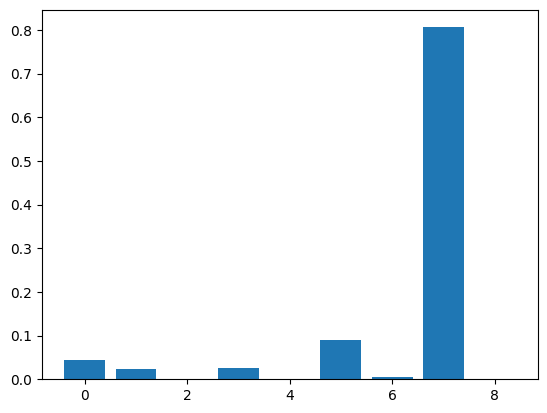

In [54]:
# check if the model has learned how to play the game
from uu import encode



tictactoe = TicTakToe()

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

state = tictactoe.get_initial_state()
state = tictactoe.get_next_state(state, 2, -1)
state = tictactoe.get_next_state(state, 4, -1)
state = tictactoe.get_next_state(state, 6, 1)
state = tictactoe.get_next_state(state, 8, 1)
print(state)

encoded_state = tictactoe.get_encoded_state(state)
print(encoded_state)

tensor_state = torch.tensor(encoded_state, device = device).unsqueeze(0)

model = ResNet(tictactoe, 4, 64, device=device)
model.load_state_dict(torch.load('model_2.pt', map_location=device) )
model.eval()

policy, value = model(tensor_state)
value = value.item()
policy = torch.softmax(policy, axis = 1).squeeze(0).detach().cpu().numpy()

print(value, policy)
plt.bar(range(tictactoe.action_size), policy)
plt.show()

In [44]:
# Nodes for our search algorithm
class Node:
    def __init__(self, game, args, state, parent = None, action_taken = None, prior= 0, visit_count = 0):
        self.game = game
        self.args = args
        self.state = state
        self.parent = parent
        self.action_taken = action_taken
        self.prior = prior
        
        # Children of our nodes
        self.children = []
        
        """no longer necessary"""
        # self.expandable_moves = game.get_valid_moves(state)
        
        self.visit_count = visit_count
        self.value_sum = 0
        
    def is_fully_expanded(self):
        """no longer necessary"""
        # return np.sum(self.expandable_moves) == 0 and len(self.children) > 0
        return len(self.children) > 0
    
    # calculating the ucb score for each leaf node and choosing the highest one
    def select(self):
        best_child = None
        best_ucp = -np.inf
        
        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucp:
                best_child = child
                best_ucp = ucb
                
        return best_child
            
    def get_ucb(self, child):
        if child.visit_count == 0:
            q_value = 0
        else:
            q_value = 1 - ((child.value_sum / child.visit_count) + 1) / 2
        return q_value + self.args['C']*(math.sqrt(self.visit_count)/(child.visit_count + 1)) * child.prior
    
    def expand(self, policy):
        
        for action, prob in enumerate(policy):
            if prob > 0:
                """no longer necessary"""
                # action = np.random.choice(np.where(self.expandable_moves == 1)[0])
                # self.expandable_moves[action] = 0
        
                child_state = self.state.copy()
                child_state = self.game.get_next_state(child_state, action, 1)
                child_state = self.game.change_perspective(child_state, player =- 1)
                
                child = Node(self.game, self.args, child_state, self, action, prob)
                self.children.append(child)
        # return child

    """no longer necessary"""
    # def simulate(self):
        
    #     value, is_terminal = self.game.get_value_and_terminated(self.state, self.action_taken)
    #     value = self.game.get_opponent_value(value)
        
    #     # check if node is terminal node
    #     if is_terminal:
    #         return value
        
    #     rollout_state = self.state.copy()
    #     rollout_player = 1
        
    #     while True:
    #         valid_moves = self.game.get_valid_moves(rollout_state)
    #         action = np.random.choice(np.where(valid_moves == 1)[0])
    #         rollout_state = self.game.get_next_state(rollout_state, action, rollout_player)
    #         value, is_terminal = self.game.get_value_and_terminated(rollout_state, action)
    #         if is_terminal:
    #             if rollout_player == 1:
    #                 value = self.game.get_opponent_value(value)
    #             return value
            
    #         rollout_player = self.game.get_opponent(rollout_player)
                    
    
    def back_propagate(self, value):
        self.value_sum += value
        self.visit_count += 1
        
        value = self.game.get_opponent_value(value)
        if self.parent is not None:
            self.parent.back_propagate(value) 

# Building the Multi Carlo Tree Search
            
class MCTS:
    def __init__(self, game, args, model):
        self.game = game
        self.args = args
        self.model = model
    
    @torch.no_grad()    
    def search(self, state):
        # define the root
        root = Node(self.game, self.args, state, visit_count = 1)
        
        policy, __ = self.model(
            torch.tensor(self.game.get_encoded_state(state), device = self.model.device).unsqueeze(0)
        )
        
        policy = torch.softmax(policy, axis = 1).squeeze().cpu().numpy()
        
        # adding noise to our policy
        policy = (1 - self.args['dirichlet_epsilon']) * policy + self.args['dirichlet_epsilon'] * \
            np.random.dirichlet([self.args['dirichlet_alpha']] * self.game.action_size)
        
        valid_moves = self.game.get_valid_moves(state)
        policy *= valid_moves
        policy /=np.sum(policy)
        
        # using policy to expand out node
        root.expand(policy)
        
        for search in range(self.args['num_searches']):
            
            node = root
            
            # selection
            while node.is_fully_expanded():
                node = node.select()
                
            value, is_terminated = self.game.get_value_and_terminated(node.state, node.action_taken)
            value = self.game.get_opponent_value(value)
            
            if not is_terminated:
                
                # no rollouts with random actions but the actions re retrieve from out model
                policy, value = self.model(
                    torch.tensor(self.game.get_encoded_state(node.state), device = self.model.device).unsqueeze(0)
                    )
               
                policy = torch.softmax(policy, axis = 1).squeeze(0).cpu().numpy()
                
                # mask out all of the illegal moves. 
                valid_moves = self.game.get_valid_moves(node.state)
                # now policies with illegal moves are effectively removed
                policy *= valid_moves 
                # rescale the policy 
                policy /= np.sum(policy)
                
                value = value.item()
                
                # expansion
                node.expand(policy)
                
                """no longer necessary"""
                # simulation
                # ( this is performing the random actions until the game is over)
                # value =  node.simulate()
                
            # back propagation (the final step)
            node.back_propagate(value)
        
        # return visit_counts
        action_probs = np.zeros(self.game.action_size)
        for child in root.children:
            action_probs[child.action_taken] = child.visit_count
        action_probs /= np.sum(action_probs)
        
        return action_probs

In [51]:
# Now creating the Alpha Zero

class AlphaZero:
    def __init__(self, model, optimizer, game, args):
        self.game = game
        self.args = args
        self.model = model
        self.optimizer = optimizer
        self.mcts = MCTS(game, args, model)
        
    def selfPlay(self):
        memory = []
        player = 1
        state = self.game.get_initial_state()
        
        while True:
            neutral_state = self.game.change_perspective(state, player)
            action_probs = self.mcts.search(neutral_state)
            memory.append((neutral_state, action_probs, player))
            
            # adding temperature
            temperature_action_probs = action_probs ** (9 / self.args['temperature'])
            
            action = np.random.choice(self.game.action_size, p=action_probs)
            state = self.game.get_next_state(state, action, player)
            value, is_terminal = self.game.get_value_and_terminated(state, action)
            
            if is_terminal:
                returnMemory = []
                for hist_neutral_state, hist_action_probs, hist_player in memory:
                    hist_outcome = value if hist_player == player else self.game.get_opponent_value(value)
                    returnMemory.append((
                        self.game.get_encoded_state(hist_neutral_state),
                        hist_action_probs, 
                        hist_outcome
                        ))
                return returnMemory
            
            player = self.game.get_opponent(player)
    
    def train(self, memory):
        random.shuffle(memory)
        #  Loop over all the memory in batches. For each we can sample a batch of different samples and train them.  
        for batchIdx in range(0, len(memory), self.args['batch_size']):     
            # sample the data
            sample = memory[batchIdx: min(len(memory) -1, batchIdx + self.args['batch_size'])]
            state, policy_targets, value_targets = zip(*sample) 
            
            state, policy_targets, value_targets = np.array(state), np.array(policy_targets), np.array(value_targets).reshape(-1, 1)
         
            # turn these into tensors
            state = torch.tensor(state, dtype=torch.float32, device=self.model.device)
            policy_targets = torch.tensor(policy_targets, dtype=torch.float32, device=self.model.device)
            value_targets = torch.tensor(value_targets, dtype=torch.float32, device=self.model.device)
            
            # Get out policy and out value from model by letting it predict the state. 
            out_policy, out_value = self.model(state)
            policy_loss = F.cross_entropy(out_policy, policy_targets)
            value_loss = F.mse_loss(out_value, value_targets)
            
            # take the sum of both of the losses to get one loss
            loss = policy_loss + value_loss
            
            # minimize the loss by back propagating
            self.optimizer.zero_grad()
            loss.backward()
            # let pytorch do the back propagation and optimize the model
            self.optimizer.step() 
            
            
    
    def learn(self):
        for iteration in range(self.args['num_iterations']):
            memory = []
            
            self.model.eval()
            for selfPlay_iteration in trange(self.args['num_selfPlay_iterations']):
                memory += self.selfPlay()
                
            self.model.train()
            for epoch in trange(self.args['num_epochs']):
                self.train(memory)
            
            torch.save(self.model.state_dict(), f'model_{iteration}.pt')
            torch.save(self.optimizer.state_dict(), f"optimizer_{iteration}.pt")

In [52]:
# training the model using the Alpha Zero model

tictactoe = TicTakToe()

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

model = ResNet(tictactoe, 4, 64, device) 

optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay=0.001)

args = {
    'C': 2,
    'num_searches': 60,
    'num_iterations': 3,
    'num_selfPlay_iterations': 500,
    'num_epochs': 4,
    'batch_size': 64,
    'temperature': 1.25,
    'dirichlet_epsilon': 0.25,
    'dirichlet_alpha': 0.3
}

alphaZero = AlphaZero(model, optimizer, tictactoe, args)
alphaZero.learn()

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [21]:
# initializing the game.

tictactoe = TicTakToe()
player = 1

args = {
    
    'C' : 2,
    'num_searches': 1000
    
}

model = ResNet(tictactoe, 4, 64)
model.eval()

mcts = MCTS(tictactoe, args, model) ##

state = tictactoe.get_initial_state()

while True:
    
    if player == 1:
    # we want the valid moves so we can know where to play
        print(state)
        valid_moves = tictactoe.get_valid_moves(state)
        print("valid moves", [i for i in range(tictactoe.action_size) if valid_moves[i] ==  1])
        # The integer input of the next move
        action = int(input(F"{player}:"))
        
        if valid_moves[action] == 0:
            print("action not valid")
            continue
    
    else:
        neutral_state = tictactoe.change_perspective(state, player)
        mcts_probs = mcts.search(neutral_state)
        action = np.argmax(mcts_probs)
        
    state = tictactoe.get_next_state(state, action, player)
    
    # check if game is terminated
    value, is_terminated = tictactoe.get_value_and_terminated(state, action)
    
    if is_terminated:
        print(state)
        # a player has won
        if value == 1:
            print(player, "won")
        else:
            print("draw") 
        break
    
    player = tictactoe.get_opponent(player)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
valid moves [0, 1, 2, 3, 4, 5, 6, 7, 8]


[[ 0.  0.  0.]
 [ 0.  1.  0.]
 [-1.  0.  0.]]
valid moves [0, 1, 2, 3, 5, 7, 8]
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [-1.  0. -1.]]
valid moves [1, 2, 3, 5, 7]
[[ 1.  0.  1.]
 [ 0.  1.  0.]
 [-1. -1. -1.]]
-1 won
